Generate and visualize 10-year average precipitation bias map

In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import Optional

import os
import pickle

import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from fme_diags.time_mean import compute_time_mean_bias, plot_time_mean_bias_list
from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference

_ = xr.set_options(keep_attrs=True)

plt.rcParams['text.usetex'] = True

In [2]:
FINETUNED = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep20-run01"
ZERO_SHOT =  "fv3gfs_zero_shot-run01"
HYBRID_STEM = "fv3gfs_hybrid_task_vector_full_finetuning_ep20-lambda"

LAMBDAS = [0.1 * i for i in range(1, 10)]

RUNS =  [ZERO_SHOT] + [
    f"{HYBRID_STEM}{lam:0.1f}-run00"
    for lam in LAMBDAS
] + [FINETUNED]

LAMBDAS = [0] + LAMBDAS + [1]

PRECIP = "surface_precipitation_rate"
OLR = "FLUT"
RSW = "top_of_atmos_upward_shortwave_flux"
PS = "PS"

VAR_LABELS = {
    PRECIP: "$P$",
    OLR: "$OLR$",
    RSW: "$RSW$",
    PS: "$p_s$",
}

In [3]:
PS_FACTOR = 0.01 
PS_UNITS = "hPa"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

FLUX_UNITS = "W/m$^2$"

def rescale_variable(x, factor: float, units=None, long_name=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
        x = x.assign_attrs(long_name=long_name)
    return x

UNIT_CONVERSIONS = {
    PRECIP: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS, long_name=VAR_LABELS[PRECIP]),
    PS: partial(rescale_variable, factor=PS_FACTOR, units=PS_UNITS, long_name=VAR_LABELS[PS]),
    OLR: partial(rescale_variable, factor=1.0, units=FLUX_UNITS, long_name=VAR_LABELS[OLR]),
    RSW: partial(rescale_variable, factor=1.0, units=FLUX_UNITS, long_name=VAR_LABELS[RSW]),
}

In [4]:
config = load_config("./preds.yaml")
run_kwargs_dict = {
    run: get_run_kwargs(config, run)
    for run in RUNS
}

In [5]:
OUTDIR = "figs/2024-05-10-hybrid-lambda-proj-bias-pattern"
os.makedirs(OUTDIR, exist_ok=True)

In [6]:
ds_dict = {
    run: open_autoregressive_inference(**run_kwargs)
    for run, run_kwargs in run_kwargs_dict.items()
}

Compute 10-year time-mean biases.

In [7]:
OVERWRITE = False

pkl = "./2024-04-28-hybrid-lambda-proj.pkl"

if os.path.isfile(pkl) and not OVERWRITE:
    with open(pkl, "rb") as f:
        time_mean_bias_dict = pickle.load(f)
else:
    time_mean_bias_dict = {
        run: compute_time_mean_bias(
            ds.sel(source="prediction"),
            ds.sel(source="target"),
        )
        for run, ds in ds_dict.items()
    }
    with open(pkl, "wb") as f:
        time_mean_bias_dict = pickle.dump(f)
    

Visualize bias patterns for each value of $\lambda$.

In [8]:
LAMBDA = "$\lambda$"

def make_lambda_bias_pattern_darray(time_mean_bias_dict, var_name):
    dvar = [
        time_mean_bias_dict[key][var_name].assign_coords(
            {LAMBDA: LAMBDAS[i]}
        ).expand_dims(
            LAMBDA, axis=0
        ).isel(sample=0)
        for i, key in enumerate(RUNS)
    ]
    darray = xr.concat(dvar, dim=LAMBDA)
    darray = UNIT_CONVERSIONS[var_name](darray)
    return darray

In [9]:
dvar_dict = {
    var_name: make_lambda_bias_pattern_darray(time_mean_bias_dict, var_name)
    for var_name in VAR_LABELS.keys()
}

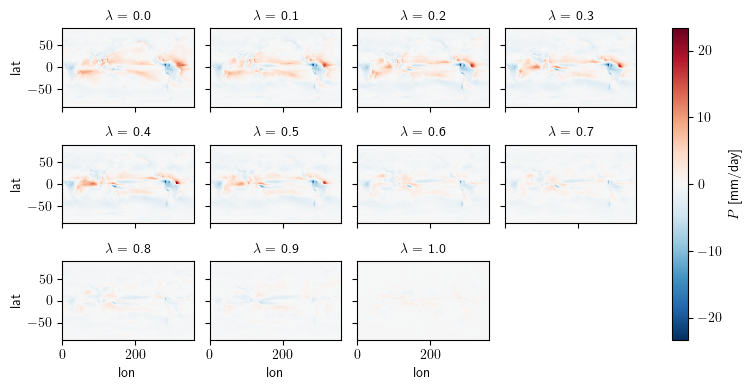

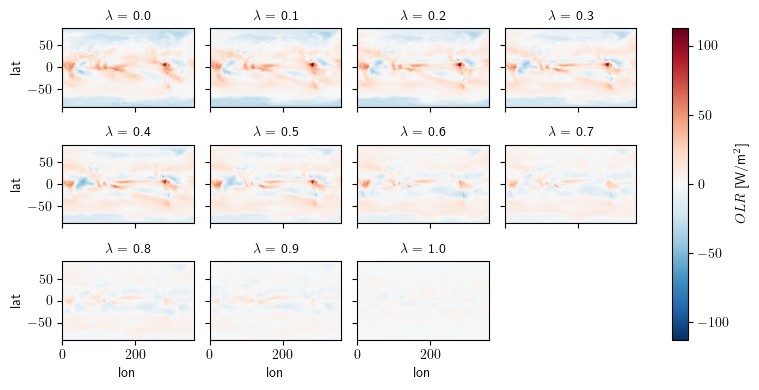

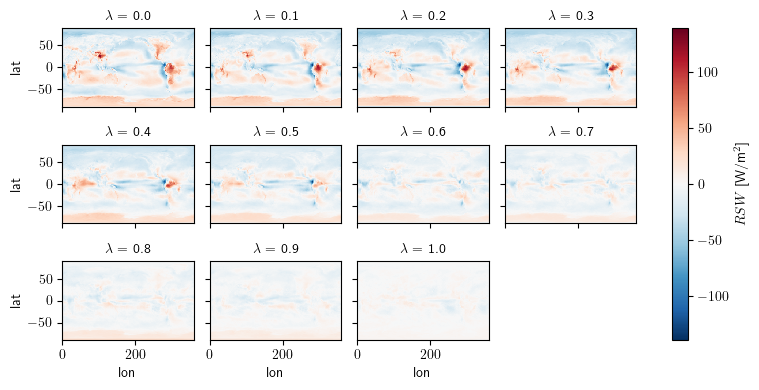

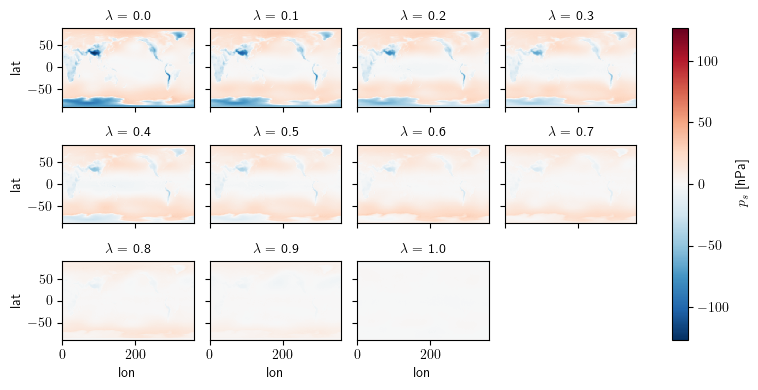

In [10]:
for var_name, darray in dvar_dict.items():
    darray.plot(
        col=LAMBDA, col_wrap=4, 
        figsize=[8, 4],
    )
    plt.show()

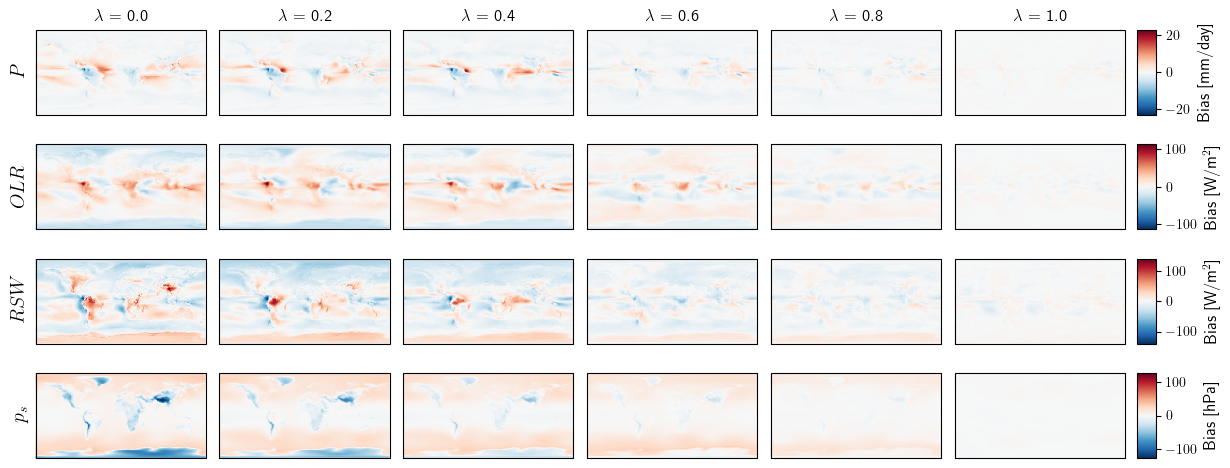

In [11]:
lambda_isel = [0, 2, 4, 6, 8, 10]

nrows = len(dvar_dict)
ncols = len(lambda_isel)

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12.5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

axs_flat = axs.flatten()
ims = []

for i, (var_name, dvar) in enumerate(dvar_dict.items()):
    
    dvar = dvar.isel({LAMBDA: lambda_isel})
    
    vmax_abs = np.abs(dvar).max().item()
    norm = TwoSlopeNorm(0.0, -vmax_abs, vmax_abs)
    
    for j, lam in enumerate(dvar[LAMBDA].values):
        ax = axs_flat[i * ncols + j]
        im = dvar.sel({LAMBDA: lam}).plot(
            ax=ax,
            norm=norm,
            cmap="RdBu_r",
            add_colorbar=False, #(j == ncols - 1),
        )
        
        if i == 0:
            ax.set_title(f"{LAMBDA} = {lam:.2}")
        else:
            ax.set_title("")
        
        if j == 0:
            ax.text(
                x=-0.15,
                y=0.5,
                s=VAR_LABELS[var_name],
                transform=ax.transAxes,
                rotation="vertical",
                verticalalignment="center",
                fontsize="x-large",
            )
    
    ims.append(im)
    
plt.tight_layout()
fig.subplots_adjust(right=0.9)    

for i, dvar in enumerate(dvar_dict.values()):
    
    ax = axs_flat[(i + 1) * ncols - 1]
    bbox = ax.get_position()
    
    # import pdb; pdb.set_trace()
    
    left = bbox.x1 + 0.01
    bottom = bbox.y0
    width = 0.015
    height = bbox.y1 - bbox.y0
    
    cbar_ax = fig.add_axes(
        [left, bottom, width, height]
    )
    cbar = fig.colorbar(
        ims[i],
        cax=cbar_ax,
        orientation="vertical",
        # extend="both",
    )
    cbar.set_label(
        f"Bias [{dvar.units}]", fontsize="large"
    )

fig.show()

In [12]:
fig.savefig(os.path.join(OUTDIR, "lambda_bias_maps.png"), bbox_inches="tight")